#Importing Library

In [ ]:
!pip install --quiet optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import scipy as sc
from scipy import signal
import cv2
import PIL
import optuna

#Data Preprocessing

##Raw Dataset

In [ ]:
df = pd.read_csv("/content/230_Users_Acceleromter_Data.csv")
df

In [ ]:
df = df.drop("Unnamed: 0",axis=1)
df

##Distributing User Data to Array

In [ ]:
length = 15000

In [ ]:
import time
start_time = time.time()
N_Users=175
k=0
X=[0 for p in range(N_Users)] # Final Array
for i in range(0,length*N_Users,length):
    temp=[]
    for j in range(length):
        x_y_z = [df.iloc[i+j,0],df.iloc[i+j,1],df.iloc[i+j,2]]
        temp.append(x_y_z)
    X[k]=temp
    print(k)
    k+=1 #incrementing [Final Array] indices
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
t=np.array(X)

##Algo for creating windows

In [ ]:
# Main Algo for Creating Windows .....#1

def create(df,wind_size,hop_size,m_index):
  #l=((len(df.x)-wind_size)/hop_size)+1
  #rows, cols = (wind_size, 3)
#  a = [[0 for i in range(cols)] for j in range(rows)]
  array= [0 for i in range(int((length-wind_size)/hop_size)+1)]
  k = 0
  for i in range(0,(length-wind_size+1),hop_size):
      a=create1(df,i,wind_size,m_index)
       #array.append(a)
      array[k] = a
      k+=1
  #return pd.DataFrame(array)
  return array


In [ ]:
# Main Algo for Creating Windows .....#2

def create1(df,x,w,m_index):
     rows = w
     cols = 3
     arr = [[0 for i in range(cols)] for j in range(rows)]
     for i in range(0,w,1):
        arr[i][0]=df[x+i][0]
        arr[i][1]=df[x+i][1]
        arr[i][2]=df[x+i][2]
     arr = np.array(arr)
     f1,t1,x = signal.stft(arr[:,0],5,nperseg=10)
     f2,t2,y = signal.stft(arr[:,1],5,nperseg=10)
     f3,t3,z = signal.stft(arr[:,2],5,nperseg=10)
     temp_a = np.concatenate((abs(np.array(x)),abs(np.array(y)),abs(np.array(z))),axis=0)
     return temp_a

## Final Array for training

In [ ]:
import time
start_time = time.time()
X_final = [0 for i in range(N_Users)]
for m_index in range(N_Users):
  X_final[m_index]=create(X[m_index],225,10,m_index)
print("--- %s seconds ---" % (time.time() - start_time))

--- 254.70773267745972 seconds ---


In [ ]:
t=np.array(X_final[0])
t.shape             # The shape gives(number of windows,shape of TF plot image)

(1478, 18, 46)

In [ ]:
X_input=[]
for i in range(N_Users):
  temp = X_final[i]
  X_input += temp
X_input = np.array(X_input)

##Creating Labels

In [ ]:
y = [0 for i in range(X_input.shape[0])]
for i in range(X_input.shape[0]):
  y[i]=int(i*N_Users/X_input.shape[0])
y = np.array(y)

##Final Input

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X_input,y,test_size = 0.2,shuffle=True)

In [ ]:
#Reshaping the input
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

# Hyperparameter Tuning

In [ ]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    #clear_session()

    filters_= trial.suggest_categorical("filters", [32, 64])
    kernel_size_= trial.suggest_categorical("kernel_size", [3, 5])
    strides_= trial.suggest_categorical("strides", [1, 2])
    activation_= trial.suggest_categorical("activation", ["relu", "linear"])
    padding_ = trial.suggest_categorical("padding", ["same"])
    pool_size_ = trial.suggest_categorical("pool_size", [1,2,3,4])

    clf = keras.Sequential()

    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_, input_shape = (X_input.shape[1],X_input.shape[2],1)))
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
    clf.add(keras.layers.Dropout(rate= 0.5))

    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
    clf.add(keras.layers.Dropout(rate= 0.5))

    clf.add(keras.layers.Flatten())

    clf.add(keras.layers.Dense(#128 493,activation='relu'))
    clf.add(keras.layers.Dense(32,activation = 'relu'))
    clf.add(keras.layers.Dense(N_Users,activation='softmax'))

    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    clf.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.RMSprop(lr=lr), metrics=["accuracy"])

    clf.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        shuffle=True,
        batch_size=128,
        epochs=25,
    )

    # Evaluate the model accuracy on the validation set.
    score = clf.evaluate(X_test,y_test,verbose=0)
    return score[1]


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    #clear_session()

    filters_= 64
    kernel_size_= 5
    strides_= 1
    activation_= "relu"
    padding_ = "same"
    pool_size_ = 2

    n_neurons = trial.suggest_int("n_neurons",64,512)

    clf = keras.Sequential()

    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_, input_shape = (X_input.shape[1],X_input.shape[2],1)))
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
    clf.add(keras.layers.Dropout(rate= 0.5))

    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
    clf.add(keras.layers.Dropout(rate= 0.5))

    clf.add(keras.layers.Flatten())

    clf.add(keras.layers.Dense(n_neurons,activation='relu'))
    clf.add(keras.layers.Dense(32,activation = 'relu'))
    clf.add(keras.layers.Dense(N_Users,activation='softmax'))

    # We compile our model with a sampled learning rate.
    clf.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.RMSprop(lr=0.0005493824470636434), metrics=["accuracy"])

    clf.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        shuffle=True,
        batch_size=128,
        epochs=25,
    )

    # Evaluate the model accuracy on the validation set.
    score = clf.evaluate(X_test,y_test,verbose=0)
    return score[1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=3000)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Model Testing

In [ ]:
clf = tensorflow.keras.Sequential()

In [ ]:

    filters_= 64
    kernel_size_= 5
    strides_= 1
    activation_= "relu"
    padding_ = "same"
    pool_size_ = 1

clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_, input_shape = (X_input.shape[1],X_input.shape[2],1)))
clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
clf.add(keras.layers.MaxPool2D(pool_size = pool_size_))
clf.add(keras.layers.Dropout(rate= 0.5))

clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
clf.add(keras.layers.MaxPool2D(pool_size = pool_size_))
clf.add(keras.layers.Dropout(rate= 0.5))

clf.add(keras.layers.Flatten())

clf.add(keras.layers.Dense(275,activation='relu'))
clf.add(keras.layers.Dense(32,activation = 'relu'))
clf.add(keras.layers.Dense(N_Users,activation='softmax'))


In [ ]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 46, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 46, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 46, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 46, 64)        102464    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 46, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 46, 64)        0

In [ ]:
clf.compile( optimizer = keras.optimizers.RMSprop(lr=0.0005493824470636434) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = clf.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_test,y_test))

Epoch 1/50
1617/1617 [==============================] - 102s 43ms/step - loss: 3.9047 - accuracy: 0.1709 - val_loss: 2.9583 - val_accuracy: 0.3205
Epoch 2/50
1617/1617 [==============================] - 70s 44ms/step - loss: 2.4858 - accuracy: 0.4076 - val_loss: 2.0531 - val_accuracy: 0.4979
Epoch 3/50
1617/1617 [==============================] - 71s 44ms/step - loss: 1.7872 - accuracy: 0.5504 - val_loss: 1.4816 - val_accuracy: 0.6205
Epoch 4/50
1617/1617 [==============================] - 72s 44ms/step - loss: 1.3613 - accuracy: 0.6428 - val_loss: 1.3438 - val_accuracy: 0.6477
Epoch 5/50
1617/1617 [==============================] - 72s 44ms/step - loss: 1.0599 - accuracy: 0.7122 - val_loss: 0.9554 - val_accuracy: 0.7430
Epoch 6/50
1617/1617 [==============================] - 72s 45ms/step - loss: 0.8470 - accuracy: 0.7638 - val_loss: 0.7151 - val_accuracy: 0.8039
Epoch 7/50
1617/1617 [==============================] - 72s 45ms/step - loss: 0.6921 - accuracy: 0.8028 - val_loss: 0.9010 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


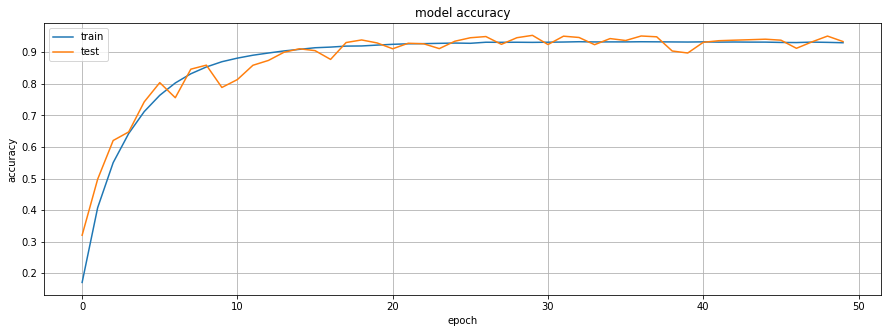

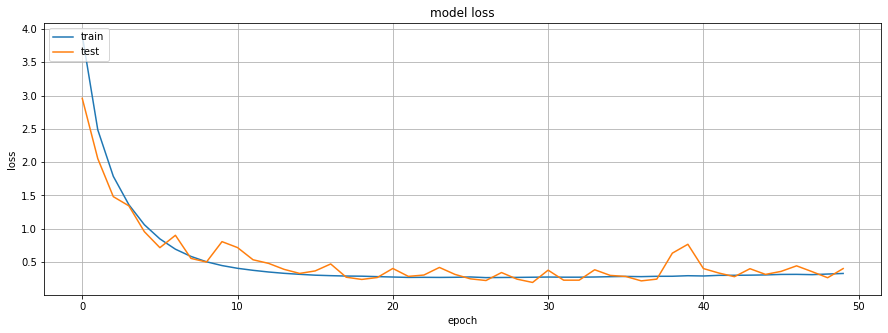

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.grid()
plt.show()

In [ ]:
from sklearn import metrics
pred_y = clf.predict(X_test)

In [ ]:
y_pred=[]
for i in range(y_test.shape[0]):
     temp=np.array(pred_y[i])
     #maximum = np.where(temp==max(temp))
     y_pred.append(np.argmax(temp))

In [ ]:
recall = metrics.recall_score(y_test, y_pred, labels=[1,2], average='micro')
precision = metrics.precision_score(y_test, y_pred, labels=[1,2], average='micro')
f1 = metrics.f1_score(y_test, y_pred, labels=[1,2], average='micro')
print('Recall: %.4f' % recall,'Precision: %.4f' % precision,'F-Measure: %.4f' % f1)

Recall: 0.8123 Precision: 0.9407 F-Measure: 0.8718


In [ ]:
metrics_df=pd.DataFrame(history.history)
metrics_df.head()

,loss,accuracy,val_loss,val_accuracy
0,3.904747,0.170902,2.958303,0.320472
1,2.485767,0.407612,2.053094,0.497874
2,1.787201,0.550445,1.481618,0.620549
3,1.361277,0.642823,1.343841,0.647709
4,1.059886,0.712188,0.955375,0.742992


In [ ]:
loss = pd.DataFrame(metrics_df.iloc[:,0].values,columns=[str(N_Users)])
accuracy = pd.DataFrame(metrics_df.iloc[:,1].values,columns=[str(N_Users)])
val_loss = pd.DataFrame(metrics_df.iloc[:,2].values,columns=[str(N_Users)])
val_accuracy = pd.DataFrame(metrics_df.iloc[:,3].values,columns=[str(N_Users)])

In [ ]:
cf_matrix=metrics.confusion_matrix(y_test,y_pred)
cf_matrix

array([[278,   0,   0, ...,   1,   0,   0],
       [  0, 241,   0, ...,   0,   0,   0],
       [  0,   0, 235, ...,   0,   0,   0],
       ...,
       [  2,   0,   0, ..., 256,   0,   0],
       [  3,   0,   0, ...,   0, 282,   0],
       [  0,   0,   0, ...,   0,   0, 261]])

# Saving Results

In [ ]:
cf_mat = pd.DataFrame(cf_matrix)
cf_mat
cf_mat.to_csv("/content/cf_mat_175.csv")

In [ ]:
loss.to_csv("/content/loss_175.csv")
accuracy.to_csv("/content/accuracy_175.csv")
val_loss.to_csv("/content/val_loss_175.csv")
val_accuracy.to_csv("/content/val_accuracy_175.csv")

In [ ]:
clf.save('/content/Model_175.h5',save_format='h5')